# Generate Anime faces using DCGAN
The following code demonstrates the implementation of Deep Convolutional Generative Adversarial Network (DCGAN) in TensorFlow on the Anime Faces dataset.
(The network architecture is based on the paper : https://arxiv.org/pdf/1511.06434.pdf )

In [1]:
import os
import numpy as np
import cv2
from glob import glob
from matplotlib import pyplot
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [2]:
#defining the dimensions of the anime images.
IMG_H = 64
IMG_W = 64
IMG_C = 3

In [3]:
#The weight initialization
w_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

### Loading and Preparing Dataset

In [4]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img)
    img = tf.image.resize_with_crop_or_pad(img, IMG_H, IMG_W)
    img = tf.cast(img, tf.float32)
    img = (img - 127.5) / 127.5
    return img

#### TensorFlow dataset pipeline for the training

In [5]:
def tf_dataset(images_path, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(images_path)
    dataset = dataset.shuffle(buffer_size=10240)
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

### The transpose convolution is used to build the generator model

In [6]:
def deconv_block(inputs, num_filters, kernel_size, strides, bn=True):
    x = Conv2DTranspose(
        filters=num_filters,
        kernel_size=kernel_size,
        kernel_initializer=w_init,
        padding="same",
        strides=strides,
        use_bias=False
        )(inputs)

    if bn:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
    return x




### The strided-convolution is used to built the discriminator model.

In [7]:
def conv_block(inputs, num_filters, kernel_size, padding="same", strides=2, activation=True):
    x = Conv2D(
        filters=num_filters,
        kernel_size=kernel_size,
        kernel_initializer=w_init,
        padding=padding,
        strides=strides,
    )(inputs)

    if activation:
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.3)(x)
    return x

## Generator 

The generator takes the random noise in the latent vector and map it to the data-space.
The generator starts with a dense or fully-connected layer. After that it is followed the series of transpose convolution, batch normalization and the leaky relu activation function.
At the last, a convolution layer with three filters and tanh activation function to generate the RGB image is used.


In [8]:
def build_generator(latent_dim):
    f = [2**i for i in range(5)][::-1]
    filters = 32
    output_strides = 16
    h_output = IMG_H // output_strides
    w_output = IMG_W // output_strides

    noise = Input(shape=(latent_dim,), name="generator_noise_input")

    x = Dense(f[0] * filters * h_output * w_output, use_bias=False)(noise)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((h_output, w_output, 16 * filters))(x)

    for i in range(1, 5):
        x = deconv_block(x,
            num_filters=f[i] * filters,
            kernel_size=5,
            strides=2,
            bn=True
        )

    x = conv_block(x,
        num_filters=3,
        kernel_size=5,
        strides=1,
        activation=False
    )
    fake_output = Activation("tanh")(x)

    return Model(noise, fake_output, name="generator")

## Discriminator

The discriminator is a simple binary classification network that takes both the real and the fake image and outputs a probability whether the given image is real or fake.

In [9]:
def build_discriminator():
    f = [2**i for i in range(4)]
    image_input = Input(shape=(IMG_H, IMG_W, IMG_C))
    x = image_input
    filters = 64
    output_strides = 16
    h_output = IMG_H // output_strides
    w_output = IMG_W // output_strides

    for i in range(0, 4):
        x = conv_block(x, num_filters=f[i] * filters, kernel_size=5, strides=2)

    x = Flatten()(x)
    x = Dense(1)(x)

    return Model(image_input, x, name="discriminator")

## Complete DCGAN Model

The GAN class denotes the complete DCGAN model with the training step defined in it. It takes the discriminator model, generator mode and the loss function. 
The train_step function is used for training the DCGAN model. The training start with the discriminator. The discriminator is first trained on the fake images generated by the generator. After that it is trained on the real images from the anime faces dataset. Next, the generator is trained based on how well the discriminator is trained.

In [10]:
class GAN(Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for _ in range(2):
            ## Train the discriminator
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            generated_images = self.generator(random_latent_vectors)
            generated_labels = tf.zeros((batch_size, 1))

            with tf.GradientTape() as ftape:
                predictions = self.discriminator(generated_images)
                d1_loss = self.loss_fn(generated_labels, predictions)
            grads = ftape.gradient(d1_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

            ## Train the discriminator
            labels = tf.ones((batch_size, 1))

            with tf.GradientTape() as rtape:
                predictions = self.discriminator(real_images)
                d2_loss = self.loss_fn(labels, predictions)
            grads = rtape.gradient(d2_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        ## Train the generator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as gtape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = gtape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {"d1_loss": d1_loss, "d2_loss": d2_loss, "g_loss": g_loss}

### Saving the images

In [11]:
def save_plot(examples, epoch, n):
    examples = (examples + 1) / 2.0
    for i in range(n * n):
        pyplot.subplot(n, n, i+1)
        pyplot.axis("off")
        pyplot.imshow(examples[i])
    filename = f"samples/generated_plot_epoch-{epoch+1}.png"
    pyplot.savefig(filename)
    pyplot.close()

# Running the code

In [16]:
if __name__ == "__main__":
    ## Hyperparameters
    batch_size = 128
    latent_dim = 128
    num_epochs = 60
    images_path = glob("data/*")

    d_model = build_discriminator()
    g_model = build_generator(latent_dim)

    # d_model.load_weights("saved_model/d_model.h5")
    # g_model.load_weights("saved_model/g_model.h5")

    d_model.summary()
    g_model.summary()

    gan = GAN(d_model, g_model, latent_dim)

    bce_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1)
    d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    gan.compile(d_optimizer, g_optimizer, bce_loss_fn)

    images_dataset = tf_dataset(images_path, batch_size)

    for epoch in range(num_epochs):
        gan.fit(images_dataset, epochs=1)
        g_model.save("saved_model/g_model.h5")
        d_model.save("saved_model/d_model.h5")

        n_samples = 25
        noise = np.random.normal(size=(n_samples, latent_dim))
        examples = g_model.predict(noise)
        save_plot(examples, epoch, int(np.sqrt(n_samples)))

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 16, 16, 128)     

169/169 [==============================] - 68s 401ms/step - d1_loss: 0.2309 - d2_loss: 0.2181 - g_loss: 3.1869


169/169 [==============================] - 67s 399ms/step - d1_loss: 0.2406 - d2_loss: 0.2113 - g_loss: 3.1641


169/169 [==============================] - 67s 399ms/step - d1_loss: 0.5296 - d2_loss: 0.2478 - g_loss: 3.1303


## Display generated images

### Images generated after epoch 1


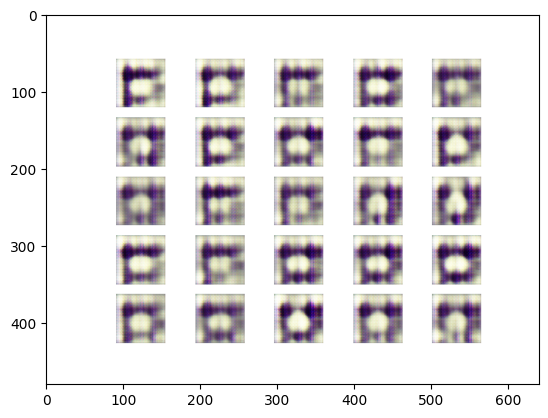

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('samples/generated_plot_epoch-1.png')
imgplot = plt.imshow(img)
plt.show()

### Images generated after epoch 60


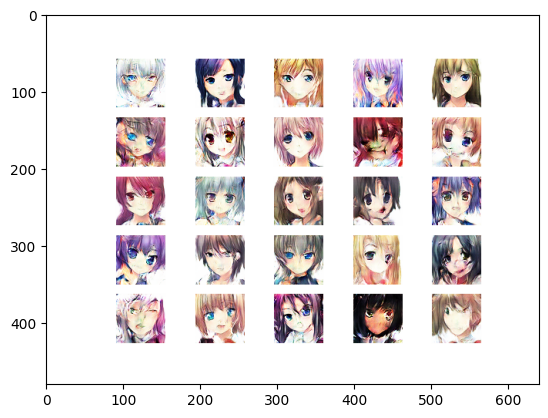

In [18]:

img = mpimg.imread('samples/generated_plot_epoch-60.png')
imgplot = plt.imshow(img)
plt.show()